In [325]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(use_memory_fs=False)

plt.style.use('seaborn-v0_8-pastel')

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


# Introduction

We're going to build a exploratory data analysis (EDA) notebook. We'll explore different kind of aspects from the following questions:
- How big is this data set?
- What fields can we find here and what they mean?
- Does this data set contain duplicated data?
- What is the data distribution by field?
- Do these fields contain nulls? How can we treat them?
- Are these fields correlated? What decisions can we make based on this?

We might answer some or all of these questions, however we'll put more enphasis on text data. For text data, we can formulate the following questions:
- How big is it? How many documents and words do we have? What is the vocabulary size?
- How long are the documents?
- Are there any missings or empty texts?
- Are there any special character in the data or emoticons?
- Are there any spelling mistakes in the data?
- What are some common words or phrases in general or by any specific category or label?
- Are there any pre-defined categories or topics associated with the text data?
- Are there any trends or patterns over time?

# Load data set

In [5]:
english_dataset = load_dataset('amazon_us_reviews', 'Video_Games_v1_00')

Generating train split:   0%|          | 0/1785997 [00:00<?, ? examples/s]

Dataset amazon_us_reviews downloaded and prepared to C:/Users/Rodrigo/.cache/huggingface/datasets/amazon_us_reviews/Video_Games_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

# Helping functions

In [6]:
def show_samples(dataset, num_samples=3, seed=18):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\n'Title: {example['review_title']}'")
        print(f"'Review: {example['review_body']}'")

def filter_books(example):
    return (
        example["product_category"] == "book"
        or example["product_category"] == "digital_ebook_purchase"
    )

# Exploratory data analysis

In [23]:
print(f'Number of documents in the dataset: {english_dataset.shape["train"][0]}')
print(f'Number of fields in the dataset: {english_dataset.shape["train"][1]}')

Number of documents in the dataset: 1785997
Number of fields in the dataset: 15


In [12]:
english_dataset['train'].features

{'marketplace': Value(dtype='string', id=None),
 'customer_id': Value(dtype='string', id=None),
 'review_id': Value(dtype='string', id=None),
 'product_id': Value(dtype='string', id=None),
 'product_parent': Value(dtype='string', id=None),
 'product_title': Value(dtype='string', id=None),
 'product_category': Value(dtype='string', id=None),
 'star_rating': Value(dtype='int32', id=None),
 'helpful_votes': Value(dtype='int32', id=None),
 'total_votes': Value(dtype='int32', id=None),
 'vine': ClassLabel(names=['N', 'Y'], id=None),
 'verified_purchase': ClassLabel(names=['N', 'Y'], id=None),
 'review_headline': Value(dtype='string', id=None),
 'review_body': Value(dtype='string', id=None),
 'review_date': Value(dtype='string', id=None)}

We notice from the feature report that some variables are binary like 'vine' and 'verified_purchase'.

# Field analysis

In [76]:
df = english_dataset['train'].to_pandas()

In [58]:
# null analysis

df.isnull().sum()

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      0
review_body          0
review_date          0
dtype: int64

No nulls detected in dataset

In [68]:
# check empty review bodies

print(f"There are {(df.review_body.str.len() == 0).value_counts()[True]} empty reviews")

There are 51 empty reviews


In [45]:
# check unique values

for field in df.columns:
    print(f"There are(is) {df[field].nunique():,} unique value(s) for {field}")

There are(is) 1 unique value(s) for marketplace
There are(is) 1,045,733 unique value(s) for customer_id
There are(is) 1,785,997 unique value(s) for review_id
There are(is) 65,792 unique value(s) for product_id
There are(is) 63,007 unique value(s) for product_parent
There are(is) 56,237 unique value(s) for product_title
There are(is) 1 unique value(s) for product_category
There are(is) 5 unique value(s) for star_rating
There are(is) 628 unique value(s) for helpful_votes
There are(is) 715 unique value(s) for total_votes
There are(is) 2 unique value(s) for vine
There are(is) 2 unique value(s) for verified_purchase
There are(is) 1,020,973 unique value(s) for review_headline
There are(is) 1,638,977 unique value(s) for review_body
There are(is) 5,906 unique value(s) for review_date


In [51]:
# check features with few unique values

print(f"Unique values in market place are: {df['marketplace'].unique()}")
print(f"Unique values in product category are: {df['product_category'].unique()}")
print(f"Unique values in star rating are: {sorted(df['star_rating'].unique())}")
print(f"Unique values in vine are: {sorted(df['vine'].unique())}")
print(f"Unique values in verified purchase are: {sorted(df['verified_purchase'].unique())}")

Unique values in market place are: ['US']
Unique values in product category are: ['Video Games']
Unique values in star rating are: [1, 2, 3, 4, 5]
Unique values in vine are: [0, 1]
Unique values in verified purchase are: [0, 1]


We'll remove market place and product category when creating the ML feature data set. This situation is obvious since we have selected US amazon reviews and just for the video game product category. Vine and verified_purchase are expected to be binary because of the variable definition

C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_15060\3032712870.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()]);


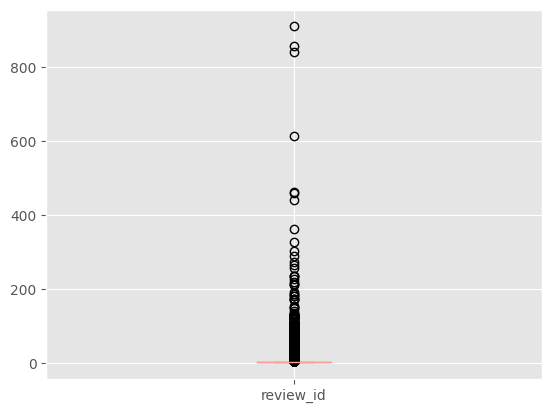

In [264]:
# reviews by customer
df.groupby('customer_id')['review_id'].count().plot(kind='box')
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()]);

In [83]:
df.groupby('customer_id')['review_id'].count().describe(percentiles=[.25,.5,.75,.9,.95,.99]).apply(lambda x: f"{x:,.3f}")

count    1,045,733.000
mean             1.708
std              3.352
min              1.000
25%              1.000
50%              1.000
75%              2.000
90%              3.000
95%              4.000
99%             11.000
max            909.000
Name: review_id, dtype: object

Up to percentile 99% we can find customers doing up to 11 reviews. There are some outliers in the dataset

In [101]:
# sample of reviews done by the customer with highest number of reviews
customers = df.groupby('customer_id')['review_id'].count()
outlier = customers[customers == 909].index[0]
df[df.customer_id == outlier].sample(10, random_state=18)[['review_id','customer_id','review_headline','review_body','review_date']]

,review_id,customer_id,review_headline,review_body,review_date
1313820,R3QKAH78YI4DKQ,52759271,a surprising technical improvement,"A sequel to the PSP's earlier \\""Portable Ops\...",2010-10-16
1393613,R14JZCMGX0TEK4,52759271,"well-made, well-executed, highly enjoyable game.",An action-RPG that prides itself on its diffic...,2009-10-16
1464237,R15U7QV60137TM,52759271,Old School Rail Shooter,Unlike the main games of the Resident Evil ser...,2008-10-21
1562028,R1RNYIVSSO7IWO,52759271,Great online team gameplay,ChromeHounds is the first Mech related adventu...,2006-09-02
1177195,RJ7NJFMZ92LKZ,52759271,Run a Ren-Faire,"A variation of the classic Sims model, \\""The ...",2011-12-24
1123175,R2QCQU3VLZCW3M,52759271,Intriguing Puzzles involving the Louvre,"With a budget price and a long, involved puzzl...",2012-05-08
1408301,RBN8YBO6XG8N8,52759271,Great Fun for Side Scrolling Fans,Castlevania - Portrait of Ruin is a classic si...,2009-07-14
1497873,R28ZKZK5XH7PW5,52759271,Great Value for the Money,"If you enjoy the Dance Dance Revolution games,...",2008-03-14
1691571,R3FIGABRVYUZ3L,52759271,Great for All Ages!,Are you completely addicted to the Sims? No? G...,2002-09-26
1592821,R1LUTDE8PG2LQB,52759271,Highly recommended!,"If you enjoy RPGs, then Jade Empire is definit...",2005-06-28


C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_15060\3748394422.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()]);


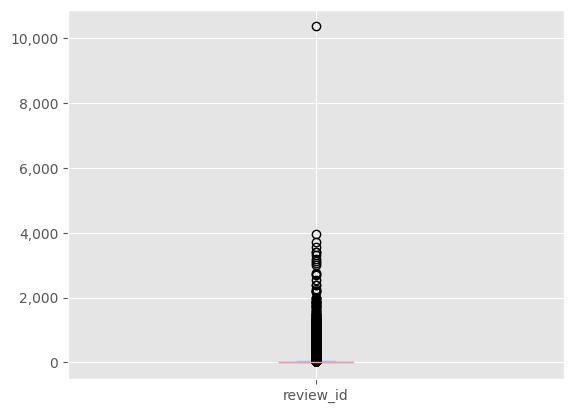

In [265]:
# check amount of reviews by product

df.groupby('product_id')['review_id'].count().plot(kind='box')
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()]);

In [104]:
df.groupby('product_id')['review_id'].count().describe(percentiles=[.25,.5,.75,.9,.95,.99]).apply(lambda x: f"{x:,.3f}")

count    65,792.000
mean         27.146
std         108.461
min           1.000
25%           1.000
50%           4.000
75%          16.000
90%          55.000
95%         111.000
99%         398.090
max      10,361.000
Name: review_id, dtype: object

<AxesSubplot: >

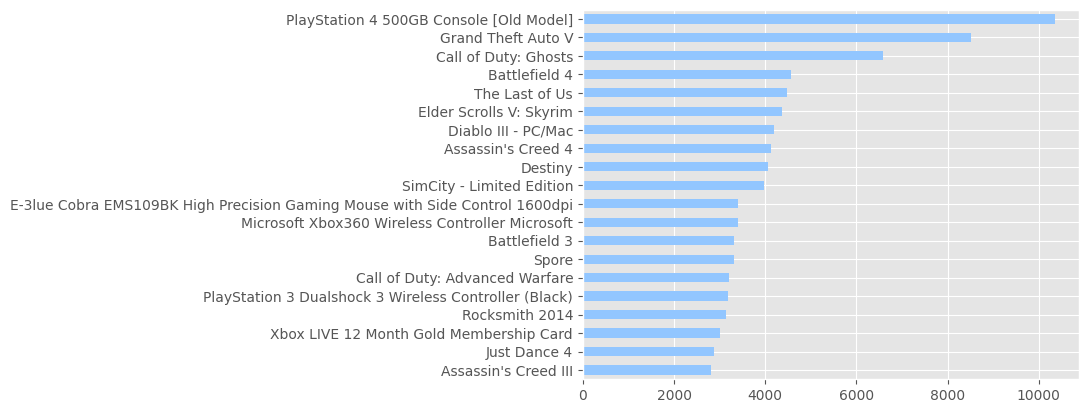

In [266]:
# sample of reviews done by the customer with highest number of reviews
products = df.groupby('product_id')['review_id'].count()
outliers = products[products >= 398].index.values
df[df.product_id.isin(outliers)].product_title.value_counts().sort_values(ascending=True).tail(20).plot(kind='barh')

C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_15060\1897469048.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()]);


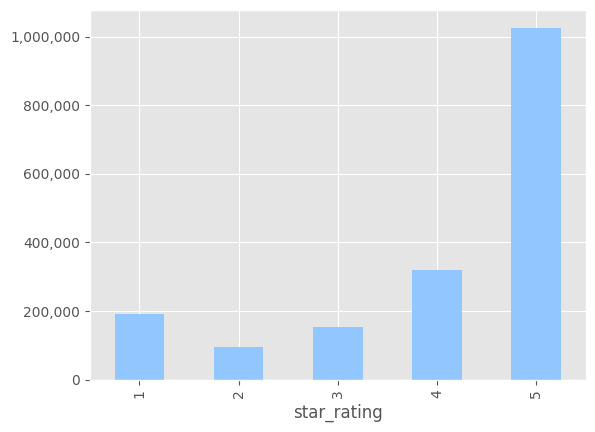

In [267]:
# check number of reviews for star rating

df.groupby('star_rating')['review_id'].count().plot(kind='bar')
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()]);

There's a clear evidence that there's a big number of videogames that are great games.

C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_15060\1355771517.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(f'{x:,.0f}' for x in plt.gca().get_yticks());


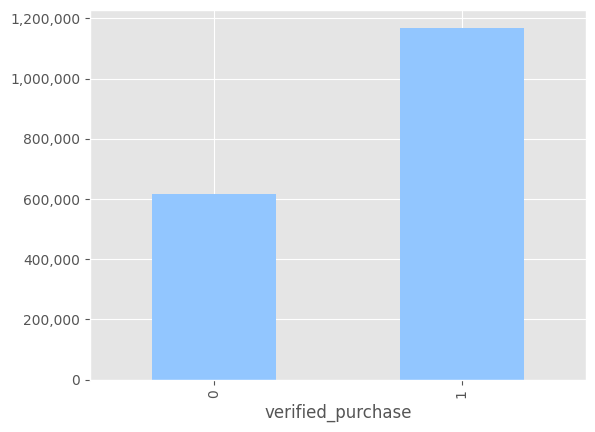

In [268]:
# check reviews by verified purchase

df.groupby('verified_purchase')['review_id'].count().plot(kind='bar')
plt.gca().set_yticklabels(f'{x:,.0f}' for x in plt.gca().get_yticks());

C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_15060\477990038.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()]);


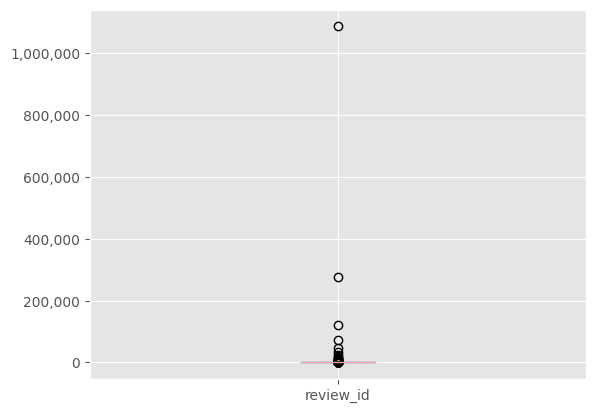

In [269]:
# check amount of reviews by helpful votes

df.groupby('helpful_votes')['review_id'].count().plot(kind='box')
plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in plt.gca().get_yticks()]);

In [231]:
df.groupby('helpful_votes')['review_id'].count().describe(percentiles=[.25,.5,.75,.9,.95,.99]).apply(lambda x: f"{x:,.3f}")

count          628.000
mean         2,843.944
std         45,165.544
min              1.000
25%              1.000
50%              3.000
75%             15.000
90%            148.500
95%            748.750
99%         22,216.740
max      1,087,671.000
Name: review_id, dtype: object

C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_15060\1622044128.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(f'{x:,.0f}' for x in ax.get_yticks())
C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_15060\1622044128.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(f'{x:,.0f}' for x in ax.get_yticks())
C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_15060\1622044128.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(f'{x:,.0f}' for x in ax.get_yticks())
C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_15060\1622044128.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_yticklabels(f'{x:,.0f}' for x in ax.get_yticks())


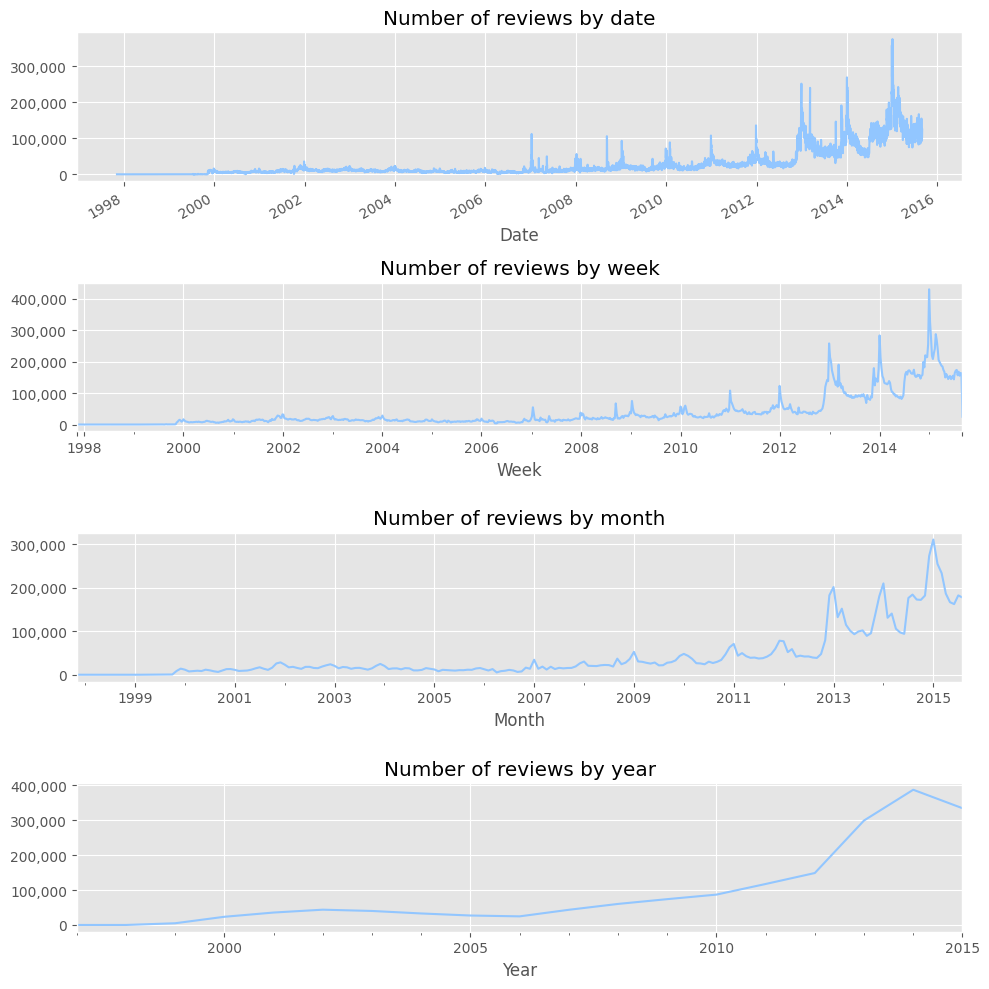

In [284]:
# check amount of reviews by date dimension
df['review_date'] = df.review_date.astype('datetime64[ns]')
df['review_week'] = df.review_date.dt.to_period('W')
df['review_month'] = df.review_date.dt.to_period('M')
df['review_year'] = df.review_date.dt.to_period('Y')

fig, axs = plt.subplots(4,1)
date_columns = ['review_date', 'review_week', 'review_month', 'review_year']
for i, column in enumerate(date_columns):
    df.groupby(column)['review_id'].count().plot(kind='line',figsize=(10,10), ax=axs[i])
    axs[i].set_xlabel(f"{(column.split('_')[1]).capitalize()}")
    axs[i].set_yticklabels(f'{x:,.0f}' for x in ax.get_yticks())
    axs[i].set_title(f"Number of reviews by {column.split('_')[1]}")
plt.tight_layout();

## Explore text fields

## Text statistics

C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_15060\169551800.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(f'{x:,.0f}' for x in ax.get_yticks())
C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_15060\169551800.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(f'{x:,.0f}' for x in ax.get_xticks())


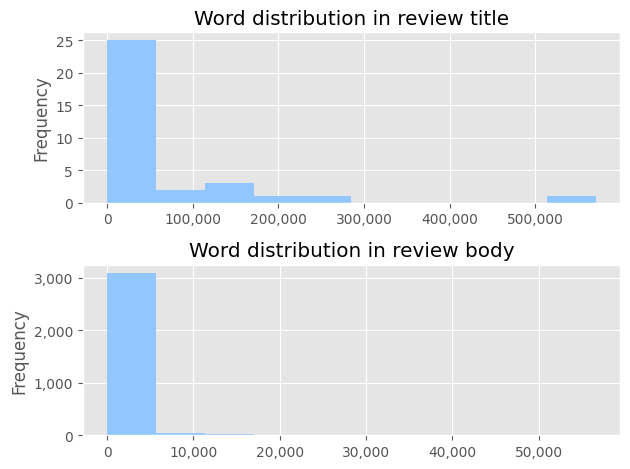

In [271]:
fig, axs = plt.subplots(2,1)
df['review_headline'].apply(lambda x: len(x.split())).value_counts().plot(kind='hist', ax=axs[0])
axs[0].set_title('Word distribution in review title')
df['review_body'].apply(lambda x: len(x.split())).value_counts().plot(kind='hist', ax=axs[1])
axs[1].set_title('Word distribution in review body')
for ax in axs:
    ax.set_yticklabels(f'{x:,.0f}' for x in ax.get_yticks())
    ax.set_xticklabels(f'{x:,.0f}' for x in ax.get_xticks())
fig.tight_layout();

C:\Users\Rodrigo\AppData\Local\Temp\ipykernel_15060\3596876898.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(f'{x:,.0f}' for x in ax.get_yticks())


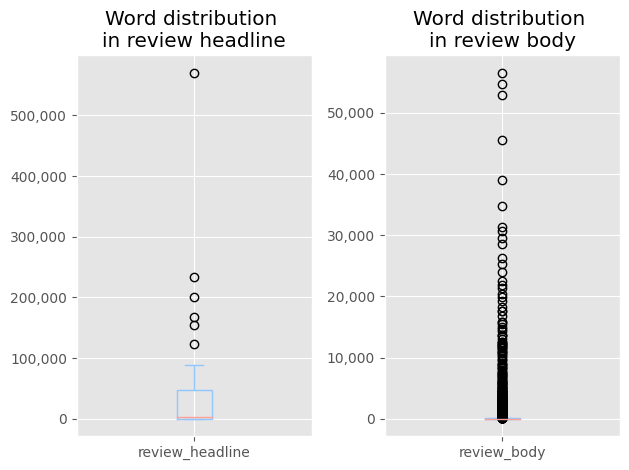

In [292]:
fig, axs = plt.subplots(1,2)
df['review_headline'].apply(lambda x: len(x.split())).value_counts().plot(kind='box', ax=axs[0])
axs[0].set_title('Word distribution\nin review headline')
df['review_body'].apply(lambda x: len(x.split())).value_counts().plot(kind='box', ax=axs[1])
axs[1].set_title('Word distribution\nin review body')
for ax in axs:
    ax.set_yticklabels(f'{x:,.0f}' for x in ax.get_yticks())
plt.tight_layout()

In [247]:
pd.DataFrame({'word_stats_headline': df['review_headline'].apply(lambda x: len(x.split())).describe(),
              'word_stats_body': df['review_body'].apply(lambda x: len(x.split())).describe()
              }).style.format('{:,.2f}')

,word_stats_headline,word_stats_body
count,"1,785,997.00","1,785,997.00"
mean,4.23,97.94
std,3.19,189.10
min,0.00,0.00
25%,2.00,20.00
50%,3.00,40.00
75%,6.00,101.00
max,32.00,"8,557.00"


In [336]:
import pyspark.pandas as ps
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .appName('my-cool-app') \
    .getOrCreate()

sample = ps.DataFrame(df[['review_headline','review_body']])
sample.review_body.apply(count_emojis)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.readRDDFromFile.
: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.api.java.JavaRDD$.readRDDFromInputStream(JavaRDD.scala:252)
	at org.apache.spark.api.java.JavaRDD$.readRDDFromFile(JavaRDD.scala:239)
	at org.apache.spark.api.python.PythonRDD$.readRDDFromFile(PythonRDD.scala:287)
	at org.apache.spark.api.python.PythonRDD.readRDDFromFile(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)


In [327]:
import emoji.unicode_codes as emj

def count_emojis(text):
    counter = 0
    for w in text.split():
        result = list(filter(lambda x: x[1] == w, emj.get_emoji_unicode_dict(lang='en').items()))
        if len(result) > 0:
            counter+=1
    return counter

In [331]:
df.review_body.apply(lambda x: count_emojis(x)).value_counts()

KeyboardInterrupt: 